Zipporah Mutua-KPSK-deKUT-02-34
✅ Maize Pest and Disease Invasion 

Goal: Predict maize pest invasion levels based on weather data.
Method: Train machine learning models using simulated weather and pest severity data.

Inputs: Max/min temperature, rainfall, humidity, wind speed.
Outputs: Risk levels (Low, Moderate, High) for:
Fall Armyworm
Maize Ear Rot
Maize Stem Borer

Use Case: Early warning for farmers and agronomists to make informed pest control decisions.

Tech Stack: Python, Scikit-learn, Streamlit (for web interface).

In [43]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [25]:
df=pd.read_csv('maize_pest_weather.csv')
df.head()

,temperature_max,temperature_min,rainfall,humidity,wind_speed,fall_armyworm,ear_rot,stem_borer
0,34.241785,21.852355,4.099033,14.556722,0.332482,Moderate,High,Moderate
1,32.654339,23.818833,3.386951,11.897629,0.385548,Low,Moderate,Moderate
2,34.619221,17.202865,2.089446,11.363602,0.320758,High,Low,High
3,36.807575,21.125938,1.029595,12.993251,0.369204,High,Low,High
4,32.414617,18.698715,3.047335,12.659631,0.210639,Moderate,Moderate,High


In [26]:
le = LabelEncoder()
df['fall_armyworm_encoded'] = le.fit_transform(df['fall_armyworm'])
df['ear_rot_encoded'] = le.fit_transform(df['ear_rot'])
df['stem_borer_encoded'] = le.fit_transform(df['stem_borer'])

In [27]:
# Features and targets
X = df[['temperature_max', 'temperature_min', 'rainfall', 'humidity', 'wind_speed']]
y_fall = df['fall_armyworm_encoded']
y_ear = df['ear_rot_encoded']
y_stem = df['stem_borer_encoded']

In [28]:
# Train-test split
X_train, X_test, y_fall_train, y_fall_test = train_test_split(X, y_fall, test_size=0.2, random_state=42)

In [30]:
# 🌽 Train Random Forest for Fall Armyworm
fall_model = RandomForestClassifier(n_estimators=100, random_state=42)
fall_model.fit(X_train, y_fall_train)

RandomForestClassifier(random_state=42)

In [31]:
# 📈 Predict on test set
y_fall_pred = fall_model.predict(X_test)

# 📊 Evaluation
print("🎯 Fall Armyworm Classification Report:")
print(classification_report(y_fall_test, y_fall_pred, target_names=le.classes_))

🎯 Fall Armyworm Classification Report:
              precision    recall  f1-score   support

        High       0.91      0.94      0.93        34
         Low       0.97      1.00      0.99        38
    Moderate       0.92      0.86      0.89        28

    accuracy                           0.94       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.94      0.94       100



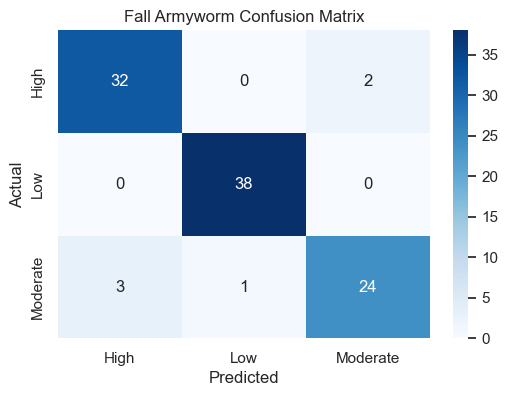

In [33]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_fall_test, y_fall_pred), annot=True, cmap="Blues", fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Fall Armyworm Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [34]:
# 📦 Feature columns
features = ['temperature_max', 'temperature_min', 'rainfall', 'humidity', 'wind_speed']

In [35]:
# 🎯 Label Encoding for targets
le_fall = LabelEncoder()
le_ear = LabelEncoder()
le_stem = LabelEncoder()

y_fall = le_fall.fit_transform(df['fall_armyworm'])
y_ear = le_ear.fit_transform(df['ear_rot'])
y_stem = le_stem.fit_transform(df['stem_borer'])

X = df[features]

In [36]:
# 🧪 Split data
X_train, X_test, y_fall_train, y_fall_test, y_ear_train, y_ear_test, y_stem_train, y_stem_test = train_test_split(
    X, y_fall, y_ear, y_stem, test_size=0.2, random_state=42)


In [37]:
# 🌽 Train models
model_fall = RandomForestClassifier(n_estimators=100, random_state=42)
model_ear = RandomForestClassifier(n_estimators=100, random_state=42)
model_stem = RandomForestClassifier(n_estimators=100, random_state=42)

In [38]:
model_fall.fit(X_train, y_fall_train)
model_ear.fit(X_train, y_ear_train)
model_stem.fit(X_train, y_stem_train)

RandomForestClassifier(random_state=42)

In [40]:
# 🧪 Predict on test set
y_fall_pred = model_fall.predict(X_test)
y_ear_pred = model_ear.predict(X_test)
y_stem_pred = model_stem.predict(X_test)

In [41]:
# 📊 Accuracy
acc_fall = accuracy_score(y_fall_test, y_fall_pred)
acc_ear = accuracy_score(y_ear_test, y_ear_pred)
acc_stem = accuracy_score(y_stem_test, y_stem_pred)

print("🎯 Model Accuracy")
print(f"Fall Armyworm: {acc_fall:.2f}")
print(f"Ear Rot: {acc_ear:.2f}")
print(f"Stem Borer: {acc_stem:.2f}")


🎯 Model Accuracy
Fall Armyworm: 0.94
Ear Rot: 0.99
Stem Borer: 0.94


In [42]:
# 📋 Optional: Detailed classification report
print("\n🧾 Classification Reports")
print("Fall Armyworm:\n", classification_report(y_fall_test, y_fall_pred, target_names=le_fall.classes_))
print("Ear Rot:\n", classification_report(y_ear_test, y_ear_pred, target_names=le_ear.classes_))
print("Stem Borer:\n", classification_report(y_stem_test, y_stem_pred, target_names=le_stem.classes_))


🧾 Classification Reports
Fall Armyworm:
               precision    recall  f1-score   support

        High       0.91      0.94      0.93        34
         Low       0.97      1.00      0.99        38
    Moderate       0.92      0.86      0.89        28

    accuracy                           0.94       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.94      0.94       100

Ear Rot:
               precision    recall  f1-score   support

        High       0.94      1.00      0.97        15
         Low       1.00      1.00      1.00        39
    Moderate       1.00      0.98      0.99        46

    accuracy                           0.99       100
   macro avg       0.98      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Stem Borer:
               precision    recall  f1-score   support

        High       0.95      0.80      0.87        25
         Low       1.00      1.00      1.00        24
    Modera

In [44]:
# 💾 Save models
joblib.dump(model_fall, "model_fall_armyworm.pkl")
joblib.dump(model_ear, "model_ear_rot.pkl")
joblib.dump(model_stem, "model_stem_borer.pkl")

['model_stem_borer.pkl']

In [45]:
# 💾 Save label encoders
joblib.dump(le_fall, "encoder_fall.pkl")
joblib.dump(le_ear, "encoder_ear.pkl")
joblib.dump(le_stem, "encoder_stem.pkl")

['encoder_stem.pkl']